### Housekeeping

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
from tensorflow import keras
from Settings import columns, experiments
import Pipeline
import matplotlib.pyplot as plt
import keras_tuner as kt
# import PCA
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib notebook
%load_ext tensorboard

In [2]:
current_exp = experiments['pca']

pipeline = Pipeline.DataClean(columns, current_exp)
pipeline.clean_data()
pipeline.norm()
pipeline.split_label()
pipeline.train_val()  

## PCA

In [3]:
pipeline.floatdata

,Azimuth Angle [degrees],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],radiance,temp,wetness,reflection
0,0.298626,0.0,0.225207,0.771111,0.149684,0.0,0.0,0.131192,0.000000,0.0
1,0.299026,0.0,0.111570,0.829167,0.150815,0.0,0.0,0.129415,0.000000,0.0
2,0.299427,0.0,0.111570,0.740833,0.151211,0.0,0.0,0.124492,0.000000,0.0
3,0.299827,0.0,0.101240,0.722778,0.150514,0.0,0.0,0.124929,0.000000,0.0
4,0.300228,0.0,0.111570,0.727222,0.149288,0.0,0.0,0.128569,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
307435,0.744789,0.0,0.000000,0.000000,0.388557,0.0,0.0,0.365390,0.040469,0.0
307436,0.745221,0.0,0.000000,0.000000,0.388764,0.0,0.0,0.364581,0.049722,0.0
307437,0.745654,0.0,0.000000,0.000000,0.389104,0.0,0.0,0.366353,0.053255,0.0
307438,0.746088,0.0,0.000000,0.000000,0.389405,0.0,0.0,0.369024,0.041310,0.0


In [ ]:
pipeline.floatdata.columns

<IPython.core.display.Javascript object>


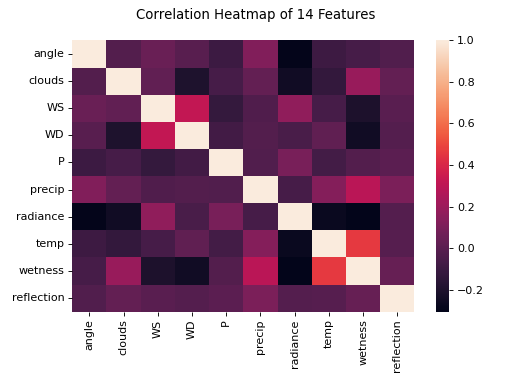

In [4]:
# srt_name = ['Irradiance','Wet Bulb', 'Radiation','Azimuth','Dew Point','RH','Cloud Cover','Max Wind','Avg Wind Deg','Pressure',
#            'Precip','Snow Depth','Moisture','Albedo']
srt_name = [col for col in columns if (col != 'IR')&(columns[col] in pipeline.floatdata.columns)]+current_exp['pca_col_names']
corr = pipeline.floatdata.corr()

cfig, cax = plt.subplots()
sns.heatmap(corr, ax=cax)
cax.set_xticklabels(srt_name)
cax.set_yticklabels(srt_name)
# plt.rcParams['figure.figsize'] = [7,7]
cfig.suptitle('Correlation Heatmap of 14 Features')
plt.tight_layout()

Look into just using environmental variable instead of using the previous persistence of solar IR

In [ ]:
pipeline.floatcols

# Model Creation

#### Model Hyperparameters

In [5]:
# setting seed
SEED = 26
# try:
#     tf.random.set_seed(SEED)
# except:
#     tf.set_random_seed(SEED)

### Skeleton
Below is creating the "skeleton" of the model. It does not need any specific data, only the shape and what it will do

Using the functional API method

In [7]:
def create_model(pipeline, exp):
    # First we start with an input layer
    input_layer = keras.layers.Input(shape=(pipeline.xtrain[0].shape)) # size per sample, equal to number of features

    # Dropout may be useful for hidden layers if the number of hidden nodes is large
    # Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
    layers = keras.layers.Dropout(exp['DROPOUT'])(input_layer)
    
    ACTIVATION = [exp['ACTIVATION']]*len(exp['HIDDENS'])
    
    for hidden,activation in zip(exp['HIDDENS'], ACTIVATION):
        layers = keras.layers.Dense(hidden, activation=activation,
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

        layers = keras.layers.Dropout(exp['DROPOUT'])(layers)

    # Output layer has a softmax function to convert output to class likelihood
    output_layer = keras.layers.Dense(pipeline.ytrain[0].shape[0], activation='softmax',
                      bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                      kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    model= keras.Model(input_layer, output_layer)
    
    return model

In [8]:
model = create_model(pipeline, current_exp)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1200)]            0         
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 90)                108090    
                                                                 
 dropout_1 (Dropout)         (None, 90)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 728       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                144   

### Compile and Train the model

In [9]:
model.compile(optimizer=current_exp['optimizer'],
             loss=keras.losses.MeanSquaredError(),
             metrics=current_exp['metrics'])

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# callbacks ensures logs are created and stored
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 

history = model.fit(x=pipeline.xtrain, 
          y=pipeline.ytrain, 
          epochs=5, 
          validation_data=(pipeline.xval, pipeline.yval), 
          callbacks=[tensorboard_callback, current_exp['EARLY_STOPPING']])

Epoch 1/5
6723/6723 [==============================] - 14s 2ms/step - loss: 232683.7344 - accuracy: 0.5114 - val_loss: 112934.1953 - val_accuracy: 0.7087
Epoch 2/5
6723/6723 [==============================] - 14s 2ms/step - loss: 232684.5625 - accuracy: 0.5220 - val_loss: 112934.1953 - val_accuracy: 0.6957
Epoch 3/5
6723/6723 [==============================] - 19s 3ms/step - loss: 232684.3281 - accuracy: 0.5111 - val_loss: 112934.2500 - val_accuracy: 0.6726
Epoch 4/5
6723/6723 [==============================] - 18s 3ms/step - loss: 232684.3438 - accuracy: 0.5188 - val_loss: 112934.1953 - val_accuracy: 0.6929
Epoch 5/5
6723/6723 [==============================] - 16s 2ms/step - loss: 232684.5781 - accuracy: 0.5220 - val_loss: 112934.2188 - val_accuracy: 0.6868


In [ ]:
# Let's plot the change in loss and accuracy
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='training')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('Dense Network Traing and Validation')
plt.tight_layout()

### Tensorboard

In [ ]:
%tensorboard --logdir logs/fit

## Predicting the Validation data

In [10]:
predict = model.predict(pipeline.xval)

<IPython.core.display.Javascript object>


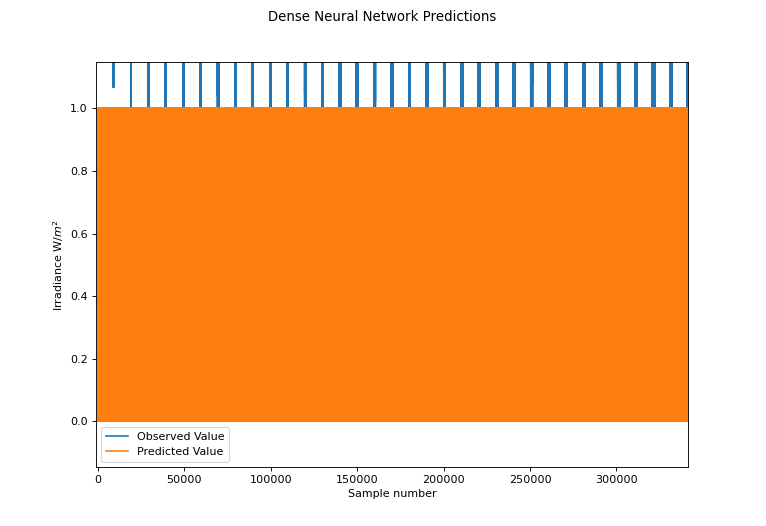

Text(0.5, 0, 'Sample number')

In [11]:
pfig, pax = plt.subplots()
pax.plot(pipeline.yval.reshape(-1), label='Observed Value')
pax.plot(predict.reshape(-1), label='Predicted Value')
pfig.suptitle('Dense Neural Network Predictions')
pax.legend()
pax.set_ylabel('Irradiance W/$m^2$')
pax.set_xlabel('Sample number')

### Keras-Tuner

In [ ]:
def reshape(data):
    return data.reshape(-1, 120, 14)

xtrain = reshape(pipeline.xtrain)
# reshape(pipeline.ytrain)
xval = reshape(pipeline.xval)
# reshape(pipeline.yval)

In [ ]:
# def model_builder(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Flatten(input_shape=(120,14)))

#   # Tune the number of units in the first Dense layer
#   # Choose an optimal value between 32-512
#   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#   model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#   model.add(keras.layers.Dense(12))

#   # Tune the learning rate for the optimizer
#   # Choose an optimal value from 0.01, 0.001, or 0.0001
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.MeanSquaredError(),
#                 metrics=['accuracy'])

#   return model



def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(120,14)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    hp_units2 = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    model.add(keras.layers.Dense(12))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

    return model







# model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))
    
# #     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
tuner.search(xtrain, pipeline.ytrain, epochs=10, validation_data=(xval, pipeline.yval), callbacks=[stop_early])

In [ ]:
tuner.search(xtrain, pipeline.ytrain, epochs=10, validation_data=(xval, pipeline.yval), callbacks=[stop_early])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
dir(tuner)
tuner.results_summary()

## Predicting the validation data